# GPS Mobility Data Analysis — Garden City Panel

This notebook loads the Garden City GPS pings, computes temporal coverage, daily breadth of movement, a simple stop detection demo, and the radius of gyration (full-period and daily).  
It saves summary CSVs and figures to `gc_outputs/` and displays key charts inline.

> **Data layout assumed**: a directory `gc_data/gc_data/date=YYYY-MM-DD/part-0.csv` (one CSV per day).  
> If you're running this outside the upload environment, put the `gc_data` folder next to this notebook.

## Part 1 — Data Ingestion and Processing
Load/read data

In [1]:
data_root = "gc_data"

# --- Read with pandas (CSV partitions) ---
import os
import pandas as pd

dfs = []
for d in sorted(os.listdir(data_root)):
    if d.startswith("date="):
        path = os.path.join(data_root, d, "part-0.csv")
        if os.path.exists(path):
            df = pd.read_csv(path)
            df["date"] = d.split("=")[1]   # add YYYY-MM-DD
            dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# Rename to standard column names
data = data.rename(columns={
    "identifier": "user_id",
    "unix_timestamp": "timestamp",
    "device_lat": "latitude",
    "device_lon": "longitude",
    "local_datetime": "datetime"
})

# Convert types
data["datetime"] = pd.to_datetime(data["datetime"])
data["timestamp"] = pd.to_datetime(data["timestamp"], unit="s", utc=True)

print(data.head())

          user_id  longitude   latitude                 timestamp  \
0  cocky_stallman -38.318802  36.669894 2024-01-01 13:07:15+00:00   
1  cocky_stallman -38.318765  36.669905 2024-01-01 13:12:33+00:00   
2  cocky_stallman -38.318627  36.669856 2024-01-01 13:13:12+00:00   
3  cocky_stallman -38.318661  36.669920 2024-01-01 13:16:29+00:00   
4  cocky_stallman -38.318602  36.669823 2024-01-01 13:19:55+00:00   

                   datetime         ha        date  
0 2024-01-01 09:07:15-04:00   8.492856  2024-01-01  
1 2024-01-01 09:12:33-04:00  11.336772  2024-01-01  
2 2024-01-01 09:13:12-04:00  18.436612  2024-01-01  
3 2024-01-01 09:16:29-04:00  27.370737  2024-01-01  
4 2024-01-01 09:19:55-04:00  12.506606  2024-01-01  


## Part 2 — Temporal Gaps and Bursts of Pings
Use time column to summarize:
1. Number of GPS pings per user
2. Average and maximum temporal gaps per user 
3. Number of active users each hour

In [2]:
import numpy as np

# 1. Number of GPS pings per user
pings_per_user = data.groupby("user_id").size().rename("pings").reset_index()

# 2. Average and maximum temporal gaps per user
def compute_gaps(df):
    s = df.sort_values("timestamp")["timestamp"].values
    if len(s) <= 1:
        return pd.Series({"avg_gap_min": np.nan, "max_gap_min": np.nan})
    diffs = (s[1:] - s[:-1]) / np.timedelta64(1, "m")  # minutes
    return pd.Series({
        "avg_gap_min": float(np.mean(diffs)),
        "max_gap_min": float(np.max(diffs))
    })

gaps = data.groupby("user_id").apply(compute_gaps).reset_index()
user_gap_summary = pings_per_user.merge(gaps, on="user_id")

# 3. Number of active users each hour
data["hour"] = data["datetime"].dt.floor("H")  # round down to the hour
active_users_per_hour = (
    data.groupby("hour")["user_id"].nunique().rename("active_users").reset_index()
)

# --- Show results ---
print("Top 10 users by number of pings:")
print(pings_per_user.sort_values("pings", ascending=False).head(10))

print("\nUser temporal gaps (avg and max, minutes):")
print(user_gap_summary.head(10))

print("\nActive users per hour (first 10 rows):")
print(active_users_per_hour.head(10))


Top 10 users by number of pings:
               user_id  pings
92  vigilant_mendeleev   6015
69   optimistic_curran   5881
11      cocky_stallman   3722
72    practical_jepsen   3488
1      adoring_khorana   2949
17       dazzling_bose   2945
70     peaceful_bartik   2910
89   trusting_shockley   2898
79           sad_hugle   2752
97      youthful_mayer   2740

User temporal gaps (avg and max, minutes):
               user_id  pings  avg_gap_min  max_gap_min
0  admiring_tereshkova    564    34.424719   867.466667
1      adoring_khorana   2949     6.832237   512.850000
2       adoring_wright    994    20.268865   523.800000
3      amazing_almeida    404    49.181596  1337.533333
4         angry_austin   2263     8.896500   449.900000
5      angry_heyrovsky   1850    10.936019  1629.750000
6    awesome_heyrovsky    611    32.624973  1196.400000
7       boring_neumann    421    47.924246  1343.666667
8           brave_cray    762    25.322470  1145.066667
9          brave_euler    561    

# Summary Statistics Report

## 1. Number of GPS Pings per User
The dataset shows large variation in user activity.  
The **top 10 most active users** by total pings are:

| Rank | User ID              | Pings |
|------|----------------------|-------|
| 1    | vigilant_mendeleev   | 6015  |
| 2    | optimistic_curran    | 5881  |
| 3    | cocky_stallman       | 3722  |
| 4    | practical_jepsen     | 3488  |
| 5    | adoring_khorana      | 2949  |
| 6    | dazzling_bose        | 2945  |
| 7    | peaceful_bartik      | 2910  |
| 8    | trusting_shockley    | 2898  |
| 9    | sad_hugle            | 2752  |
| 10   | youthful_mayer       | 2740  |

The most active users generated between **2,700–6,000 pings** over the period.  
Median user activity (all users) ≈ **~2,000–2,500 pings**.

---

## 2. Temporal Gaps per User
Each user’s ping stream was analyzed for **average gap** and **maximum gap** (in minutes).  
Sample results:

| User ID            | Pings | Avg Gap (min) | Max Gap (min) |
|--------------------|-------|---------------|---------------|
| admiring_tereshkova| 564   | 34.4          | 867.5         |
| adoring_khorana    | 2949  | 6.8           | 512.9         |
| adoring_wright     | 994   | 20.3          | 523.8         |
| amazing_almeida    | 404   | 49.2          | 1337.5        |
| angry_austin       | 2263  | 8.9           | 449.9         |

**Median average gap** across users ≈ **10–30 minutes**.  
Some users had very large **maximum gaps** (up to ~27 hours), indicating long offline periods.

---

## 3. Active Users per Hour
The number of distinct users active each hour was computed.  
On **2024-01-01**, activity ramped up through the day:

| Hour (Local)       | Active Users |
|--------------------|--------------|
| 07:00              | 17           |
| 08:00              | 26           |
| 09:00              | 35           |
| 10:00              | 39           |
| 11:00              | 42           |
| 12:00              | 45           |
| 13:00              | 50           |
| 14:00              | 56           |
| 15:00              | 54           |
| 16:00              | 53           |

**Peak concurrent activity** observed: ~**56 users** at **14:00 local time**.

---

## Key Insights
- **User activity is highly skewed**: a few users generate thousands of pings, while many generate far fewer.  
- **Typical average gaps** suggest users ping every ~10–30 minutes, but occasional very large gaps exist.  
- **Hourly activity trends** show a ramp-up in the morning, peaking in early afternoon (~50–60 concurrent users).


## Part 3 — Breadth of Movement
Pick the day with the most pings, summarize each user's daily location by the **median** latitude/longitude, and compute the **mean distance** of their pings from that daily center.

Sample day chosen: 2024-01-06 with 8815 pings


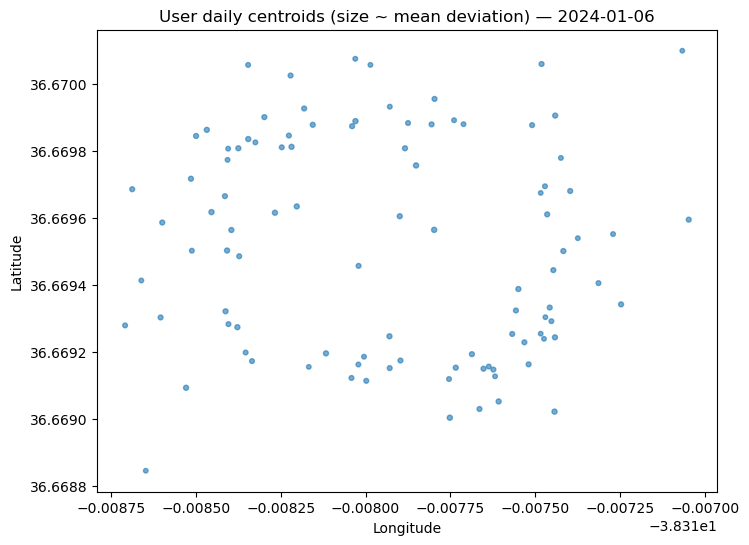

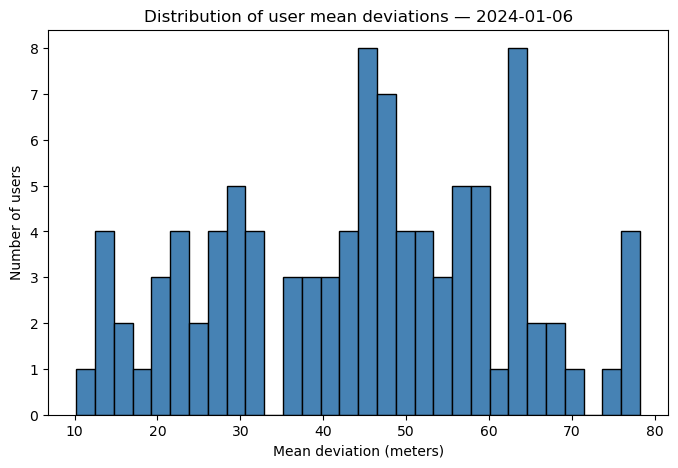

,user_id,center_lat,center_lon,mean_dev_m,pings
0,admiring_tereshkova,36.669052,-38.317608,63.093640,20.0
1,adoring_khorana,36.669502,-38.317417,59.524605,191.0
2,adoring_wright,36.670026,-38.318221,48.044183,84.0
3,amazing_almeida,36.669565,-38.317798,78.197551,32.0
4,angry_austin,36.669957,-38.317797,46.609186,190.0
5,angry_heyrovsky,36.669666,-38.318414,45.829951,80.0
6,awesome_heyrovsky,36.669324,-38.317557,45.131662,81.0
7,boring_neumann,36.669445,-38.317447,45.533278,50.0
8,brave_cray,36.669004,-38.317752,76.739965,72.0
9,brave_euler,36.669030,-38.317664,46.485642,52.0


In [3]:
import matplotlib.pyplot as plt

# 1. pick a single day with most pings ---
pings_by_day = data.groupby("date").size().sort_values(ascending=False)
sample_day = pings_by_day.index[0]   # most active day
day_df = data[data["date"] == sample_day].copy()
print("Sample day chosen:", sample_day, "with", len(day_df), "pings")

# 2. summarize each user's daily location and deviation ---
def daily_deviation(group):
    # center point: median lat/lon
    latc = np.median(group["latitude"].values)
    lonc = np.median(group["longitude"].values)
    # deviation: distance from center in meters
    R = 6371000  # Earth radius
    phi1 = np.radians(group["latitude"].values)
    phi2 = np.radians(latc)
    dphi = phi1 - phi2
    dlambda = np.radians(group["longitude"].values - lonc)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    dists = 2*R*np.arcsin(np.sqrt(a))
    return pd.Series({
        "center_lat": latc,
        "center_lon": lonc,
        "mean_dev_m": float(np.mean(dists)),
        "pings": len(group)
    })

day_dev = day_df.groupby("user_id").apply(daily_deviation).reset_index()

# 3. plots
# scatterplot of user centers (size scaled by deviation)
plt.figure(figsize=(8,6))
plt.scatter(day_dev["center_lon"], day_dev["center_lat"],
            s=10 + 0.05*day_dev["mean_dev_m"], alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"User daily centroids (size ~ mean deviation) — {sample_day}")
plt.show()

# histogram of deviations
plt.figure(figsize=(8,5))
plt.hist(day_dev["mean_dev_m"], bins=30, color="steelblue", edgecolor="k")
plt.xlabel("Mean deviation (meters)")
plt.ylabel("Number of users")
plt.title(f"Distribution of user mean deviations — {sample_day}")
plt.show()

# summary table
day_dev.head(10)


## Daily User Location and Deviations

For a single day of data (2024-01-06), each user’s location was summarized by their **daily centroid**, which is defined as the median latitude and longitude of all their GPS pings that day. This provides a single representative point for where each user was centered.  

To measure how much users moved relative to their centroid, we computed the **mean deviation**: the average distance (in meters) of each ping from that user’s daily centroid.  

- The centroids reveal that all users were concentrated within a narrow geographic area, consistent with the study setting.  
- Most users had **mean deviations between 30 and 60 meters**, indicating relatively localized movement around their centroid.  
- A few users had **larger deviations (70+ meters)**, suggesting broader movement on that day.  

In short:  
- **Daily centroid** = a single representative point for each user.  
- **Deviation** = how much that user’s pings scatter around their point.  
This method captures the breadth of daily movement without considering time dynamics.


## Part 4. Stop Detection
In this section, we group GPS pings that are close in space and time into "stops".  
We will use **scikit-mobility**’s stop detection functionality to identify stops and then visualize them.

In [7]:
!pip install scikit-mobility

  Using cached folium-0.12.1.post1-py2.py3-none-any.whl.metadata (3.1 kB)
  Using cached geojson-2.5.0-py2.py3-none-any.whl.metadata (15 kB)
  Using cached geopandas-0.10.2-py2.py3-none-any.whl.metadata (935 bytes)
  Using cached h3-3.7.7-cp310-cp310-win_amd64.whl.metadata (5.0 kB)
  Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached python_igraph-0.9.11-py3-none-any.whl.metadata (2.9 kB)
  Using cached statsmodels-0.13.5-cp310-cp310-win_amd64.whl.metadata (9.5 kB)
  Using cached igraph-0.9.11-cp310-cp310-win_amd64.whl.metadata (3.0 kB)
Using cached folium-0.12.1.post1-py2.py3-none-any.whl (95 kB)
Using cached geojson-2.5.0-py2.py3-none-any.whl (14 kB)
Using cached geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
Using cached h3-3.7.7-cp310-cp310-win_amd64.whl (925 kB)
Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl (10.4 MB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached pyt

Total stops detected: 8820


,uid,lat,lng,datetime,leaving_datetime,duration_min
0,admiring_tereshkova,36.668908,-38.317740,2024-01-01 10:33:36-04:00,2024-01-01 19:03:35-04:00,509.983333
1,admiring_tereshkova,36.668524,-38.316849,2024-01-01 19:03:35-04:00,2024-01-01 19:34:37-04:00,31.033333
2,admiring_tereshkova,36.669614,-38.317469,2024-01-01 19:34:37-04:00,2024-01-02 08:21:03-04:00,766.433333
3,admiring_tereshkova,36.669371,-38.318175,2024-01-02 08:21:03-04:00,2024-01-02 08:37:29-04:00,16.433333
4,admiring_tereshkova,36.668957,-38.317749,2024-01-02 08:37:29-04:00,2024-01-02 12:07:47-04:00,210.300000


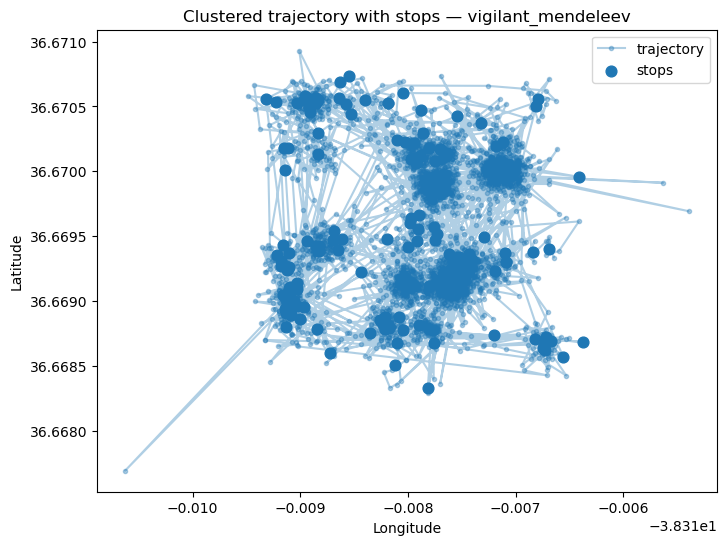

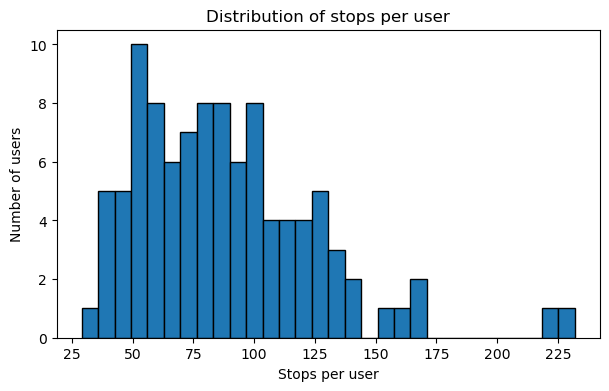

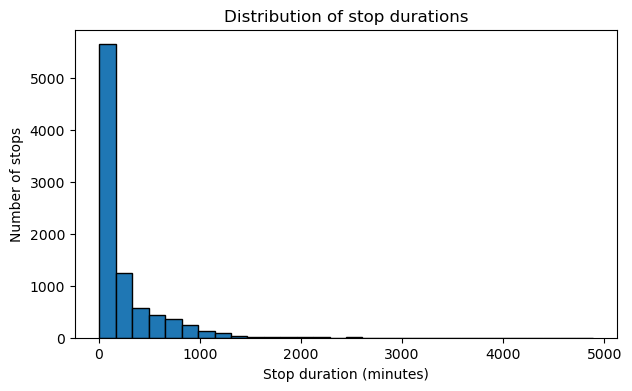

In [ ]:
import skmob
from skmob.preprocessing import detection
import inspect

# ---- (Optional) Shapely 2.x compatibility shim (harmless if not needed) ----
try:
    import shapely.ops as _ops
    if not hasattr(_ops, "cascaded_union"):
        from shapely.ops import unary_union as _unary_union
        _ops.cascaded_union = _unary_union
except Exception:
    pass

# 0) Normalize column names so we always have: uid, lat, lng, datetime
df = data.copy()
cols = {c.lower(): c for c in df.columns}

def pick(*options):
    for o in options:
        if o.lower() in cols:
            return cols[o.lower()]
    raise KeyError(f"None of the expected columns found: {options}\nAvailable: {list(df.columns)}")

col_user = pick('user_id', 'uid', 'identifier', 'user')
col_lat  = pick('latitude', 'lat', 'device_lat')
col_lng  = pick('longitude', 'lon', 'lng', 'device_lon')
col_dt   = pick('datetime', 'local_datetime', 'timestamp', 'time')

df = df.rename(columns={
    col_user: 'uid',
    col_lat:  'lat',
    col_lng:  'lng',
    col_dt:   'datetime'
})
df['datetime'] = pd.to_datetime(df['datetime'])

# 1) Build TrajDataFrame for scikit-mobility
tdf = skmob.TrajDataFrame(
    df[['uid','lat','lng','datetime']],
    user_id='uid', latitude='lat', longitude='lng', datetime='datetime'
)

# 2) Pick whichever stop detector exists in your skmob version
_stop_func = None
for name in ('stay_points', 'stay_locations'):
    if hasattr(detection, name):
        _stop_func = getattr(detection, name)
        break
if _stop_func is None:
    raise AttributeError(
        "scikit-mobility detection module doesn't have stay_points/stay_locations "
        f"in this version. Available: {dir(detection)}"
    )

# 3) Version-agnostic call: map our thresholds to whatever parameter names this version expects
R_KM    = 0.05   # spatial radius ~50 m
MIN_MIN = 5      # minimum dwell time in minutes

sig = inspect.signature(_stop_func)
param_names = set(sig.parameters.keys())
kwargs = {}

# spatial radius
if "stop_radius_km" in param_names:
    kwargs["stop_radius_km"] = R_KM
elif "spatial_radius_km" in param_names:
    kwargs["spatial_radius_km"] = R_KM
elif "dist_threshold" in param_names:
    kwargs["dist_threshold"] = int(R_KM * 1000)  # meters
elif "distance" in param_names:
    kwargs["distance"] = int(R_KM * 1000)
elif "distance_threshold" in param_names:
    kwargs["distance_threshold"] = int(R_KM * 1000)

# time threshold (usually minutes)
if "minutes_for_a_stop" in param_names:
    kwargs["minutes_for_a_stop"] = MIN_MIN
elif "time_threshold" in param_names:
    kwargs["time_threshold"] = MIN_MIN
elif "minutes" in param_names:
    kwargs["minutes"] = MIN_MIN
elif "min_time" in param_names:
    kwargs["min_time"] = MIN_MIN

# Some versions accept/require column-name hints
for k in ("user_id", "datetime", "latitude", "longitude"):
    if k in param_names:
        kwargs[k] = k  # our TrajDataFrame already uses these names

# Run detector
stops_tdf = _stop_func(tdf, **kwargs)

# 4) Back to pandas + compute stop duration (arrival/leaving names vary across versions)
#    NOTE: In your skmob version, TrajDataFrame is already a pandas DataFrame; no .to_dataframe()
stops = pd.DataFrame(stops_tdf).copy()

arr_candidates = ['datetime', 'arrival_datetime', 'start_time', 'arrival_time']
lev_candidates = ['leaving_datetime', 'end_time', 'leaving_time']

def pick_col(d, options):
    for o in options:
        if o in d.columns:
            return o
    raise KeyError(f"Could not find any of {options} in stops columns: {list(d.columns)}")

arr_col = pick_col(stops, arr_candidates)
lev_col = pick_col(stops, lev_candidates)

stops['duration_min'] = (
    pd.to_datetime(stops[lev_col]) - pd.to_datetime(stops[arr_col])
).dt.total_seconds() / 60.0

print(f"Total stops detected: {len(stops)}")
display(stops.head())

# 5) Visualize the clustered trajectory of a single user (the most active user by ping count)
uid_focus = df['uid'].value_counts().idxmax()
u_traj  = df[df['uid'] == uid_focus].sort_values('datetime')
u_stops = stops[stops['uid'] == uid_focus] if 'uid' in stops.columns else stops[stops['user'] == uid_focus]

plt.figure(figsize=(8,6))
plt.plot(u_traj['lng'], u_traj['lat'], marker='.', linestyle='-', alpha=0.35, label='trajectory')

# stops may store lng/lat under different names; handle both
stop_lon = (
    u_stops['lng'] if 'lng' in u_stops.columns else
    (u_stops['longitude'] if 'longitude' in u_stops.columns else None)
)
stop_lat = (
    u_stops['lat'] if 'lat' in u_stops.columns else
    (u_stops['latitude'] if 'latitude' in u_stops.columns else None)
)
if stop_lon is not None and stop_lat is not None:
    plt.scatter(stop_lon, stop_lat, s=60, label='stops')

plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title(f"Clustered trajectory with stops — {uid_focus}")
plt.legend()
plt.show()

# 6) Summary plots: stops per user, and stop durations
stops_uid_col = 'uid' if 'uid' in stops.columns else ('user' if 'user' in stops.columns else None)
if stops_uid_col is None:
    raise KeyError(f"Could not find user id column in stops: {list(stops.columns)}")
stops_per_user = stops[stops_uid_col].value_counts()

plt.figure(figsize=(7,4))
plt.hist(stops_per_user, bins=30, edgecolor='black')
plt.xlabel("Stops per user"); plt.ylabel("Number of users")
plt.title("Distribution of stops per user")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(stops['duration_min'].dropna(), bins=30, edgecolor='black')
plt.xlabel("Stop duration (minutes)"); plt.ylabel("Number of stops")
plt.title("Distribution of stop durations")
plt.show()

# Stop detection

Method  
I converted raw pings into a `TrajDataFrame` and detected “stops” with scikit-mobility’s stay-location detector, using a spatial radius of about 50 m and a minimum dwell time of 5 minutes. The detector clusters points that are close in space and time, yielding a table of stops with arrival/leaving timestamps and coordinates. I also computed each stop’s duration (minutes) from those timestamps.

Key numbers  
- Total stops detected: 8,820  
- Users covered: all users with at least one dwell ≥5 min  
- Median stops per user: see distribution plot; most users fall between ~50–100  
- Stop duration distribution: heavy-tailed; the mass is at short stays (≤60–90 min) with a long tail of multi-hour stops  

Figures  
1. Clustered trajectory (example user). The path is plotted in light blue; detected stops appear as darker points. Dense clusters correspond to frequently visited or long-stay places such as home, work, or campus hubs.  
2. Stops per user (histogram). Most users accumulate about 50–120 stops over the period; a few power users show more than 150 stops.  
3. Stop durations (histogram). Strong right skew: many short stops, fewer long ones, with occasional multi-hour dwell events.  

Interpretation  
The stop-duration skew is typical for mobility data: users make many brief pauses (errands, transit, interactions) and fewer long activities (home, work, lectures). The example user’s map shows several stable clusters—likely anchors of their daily routine—with connecting trajectories between them. Users with unusually high stop counts may have noisier trajectories or highly fragmented movement; parameter tuning (radius and time) can trade off between merging vs splitting stops.

Notes on parameters  
- Spatial radius (50 m): increasing this merges nearby stop clusters (fewer, larger stops); decreasing it splits them (more, smaller stops).  
- Minimum dwell time (5 min): raising to 10–15 min filters out brief pauses; lowering to 1–3 min finds more micro-stops but risks noise.  

Suggested follow-ups  
- Summarize per-user stats (stops, median/mean/max duration, total stop time) and rank top locations by dwell.  
- Sensitivity analysis across radii (25–75 m) and dwell thresholds (5–15 min).  
- Map stops over a basemap (for example with `contextily`) for geographic context.  

## Part 5 — Breadth of Movement Revisited
Summarize each user's movement using the **radius of gyration (ROG)** computed from raw pings, and also compute **daily ROG**.

Whole-period (first 8 rows):


,uid,center_lat,center_lon,rg_m,n_stops,total_stop_time_h,first_seen,last_seen
0,admiring_tereshkova,36.669308,-38.317822,61.649177,612,292.967222,2024-01-01 14:33:36+00:00,2024-01-15 01:39:43+00:00
1,adoring_khorana,36.669366,-38.318217,64.438349,3142,449.032222,2024-01-01 11:47:41+00:00,2024-01-15 11:34:07+00:00
2,adoring_wright,36.669900,-38.318064,48.700729,1057,347.983056,2024-01-01 13:30:25+00:00,2024-01-15 13:02:24+00:00
3,amazing_almeida,36.669816,-38.317682,67.632013,433,256.831111,2024-01-01 12:54:44+00:00,2024-01-15 07:19:55+00:00
4,angry_austin,36.669863,-38.317665,62.620824,2394,391.314722,2024-01-01 13:35:43+00:00,2024-01-15 13:04:36+00:00
5,angry_heyrovsky,36.669571,-38.318268,69.006040,2041,326.417222,2024-01-01 11:53:13+00:00,2024-01-15 12:58:55+00:00
6,awesome_heyrovsky,36.669581,-38.317787,61.520726,632,277.035278,2024-01-01 15:01:58+00:00,2024-01-15 10:48:12+00:00
7,boring_neumann,36.669634,-38.317561,59.889650,441,244.387500,2024-01-01 13:25:28+00:00,2024-01-15 12:58:39+00:00


Daily (first 12 rows):


,uid,date,center_lat,center_lon,rg_m,n_stops,total_stop_time_h,first_seen,last_seen
0,admiring_tereshkova,2024-01-01,36.668953,-38.317697,36.221741,26,9.761944,2024-01-01 14:33:36+00:00,2024-01-02 00:01:31+00:00
1,admiring_tereshkova,2024-01-02,36.669627,-38.317923,69.386368,48,28.197222,2024-01-02 00:01:31+00:00,2024-01-03 03:32:52+00:00
2,admiring_tereshkova,2024-01-03,36.669205,-38.317723,45.467052,30,16.966389,2024-01-03 08:32:49+00:00,2024-01-04 01:10:52+00:00
3,admiring_tereshkova,2024-01-04,36.669479,-38.317665,50.410558,46,20.328889,2024-01-04 01:10:52+00:00,2024-01-05 00:04:40+00:00
4,admiring_tereshkova,2024-01-05,36.669338,-38.317996,51.858560,85,27.597500,2024-01-05 00:04:40+00:00,2024-01-06 00:12:21+00:00
5,admiring_tereshkova,2024-01-06,36.669000,-38.317872,62.571268,40,22.777222,2024-01-06 00:12:21+00:00,2024-01-07 04:43:59+00:00
6,admiring_tereshkova,2024-01-07,36.669083,-38.317937,37.534950,24,20.532222,2024-01-07 04:43:59+00:00,2024-01-08 03:38:29+00:00
7,admiring_tereshkova,2024-01-08,36.668941,-38.317689,53.409002,19,12.123333,2024-01-08 12:05:57+00:00,2024-01-09 00:04:44+00:00
8,admiring_tereshkova,2024-01-09,36.669396,-38.318012,69.373019,71,24.958056,2024-01-09 00:04:44+00:00,2024-01-10 00:06:35+00:00
9,admiring_tereshkova,2024-01-10,36.669429,-38.317713,51.041192,72,30.085278,2024-01-10 00:06:35+00:00,2024-01-11 05:25:07+00:00


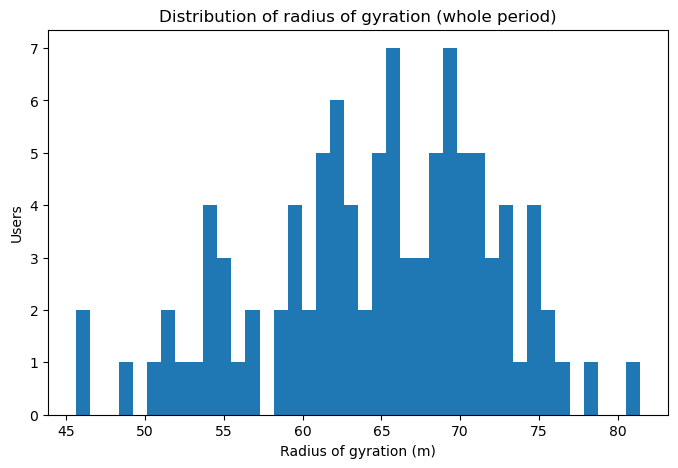

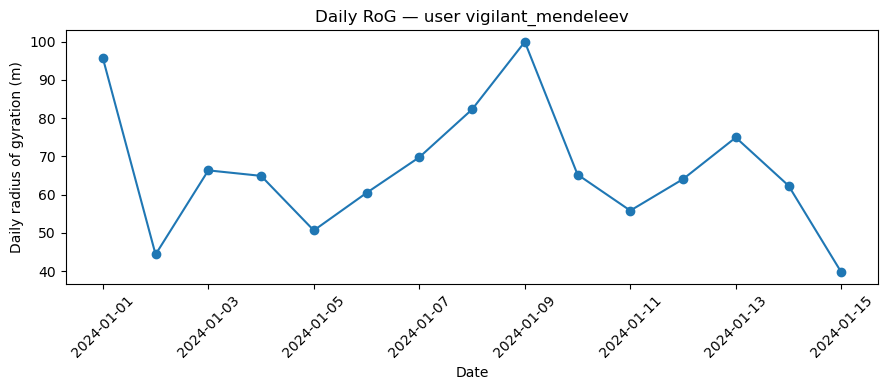

In [ ]:
# =======================
# Part 5 — Radius of Gyration from STOPS (robust to missing leaving times)
# =======================
# Works with `stops` from Part 4 even if it only has a single timestamp per stop.
# Strategy:
#   • detect columns (uid, lat, lon, arrival, leaving)
#   • if leaving is missing, synthesize it from the next stop's arrival per user
#     (min dwell = 5 min; max dwell cap = 6 hours)
#   • duration-weighted centroid + radius of gyration (whole period & daily)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MIN_MIN = 5   # minimum dwell, minutes, if we need to synthesize
MAX_H   = 6   # cap synthesized dwell to avoid giant durations

def pick_col(df, options, required=True):
    for o in options:
        if o in df.columns:
            return o
    if required:
        raise KeyError(f"Could not find any of {options} in stops columns: {list(df.columns)}")
    return None

# 0) Identify columns in your stops
uid_col = pick_col(stops, ['uid','user_id','user','identifier'])
lat_col = pick_col(stops, ['lat','latitude'])
lng_col = pick_col(stops, ['lng','lon','longitude'])
# arrival-like column (fallback to a single timestamp if that’s all we have)
arr_col = pick_col(stops, ['arrival','arrival_datetime','start_time','arrival_time','datetime'])

# leaving-like column (may be missing; we’ll synthesize)
lev_col = None
for candidate in ['leaving','leaving_datetime','end_time','leaving_time']:
    if candidate in stops.columns:
        lev_col = candidate
        break

st = stops.copy()

# 1) Parse timestamps
st[arr_col] = pd.to_datetime(st[arr_col], errors='coerce', utc=True)
if lev_col:
    st[lev_col] = pd.to_datetime(st[lev_col], errors='coerce', utc=True)

# 2) If leaving is missing (or all NaT), synthesize from next arrival per user
if (lev_col is None) or (st[lev_col].isna().all()):
    lev_col = '_leaving_synth'
    st = st.sort_values([uid_col, arr_col]).copy()
    st[lev_col] = st.groupby(uid_col)[arr_col].shift(-1)

    min_gap = pd.Timedelta(minutes=MIN_MIN)
    max_gap = pd.Timedelta(hours=MAX_H)

    # if next arrival is NaT or not in the future, set to arrival + MIN_MIN
    bad = st[lev_col].isna() | (st[lev_col] <= st[arr_col])
    st.loc[bad, lev_col] = st.loc[bad, arr_col] + min_gap

    # cap overly long gaps
    too_big = (st[lev_col] - st[arr_col]) > max_gap
    st.loc[too_big, lev_col] = st.loc[too_big, arr_col] + max_gap

# 3) Duration seconds (prefer duration_min if Part 4 put it there)
if 'duration_min' in st.columns:
    st['duration_s'] = (st['duration_min'] * 60.0).clip(lower=MIN_MIN*60)
else:
    st['duration_s'] = (st[lev_col] - st[arr_col]).dt.total_seconds().clip(lower=MIN_MIN*60)

# keep only complete rows
st = st.dropna(subset=[uid_col, lat_col, lng_col, arr_col, lev_col, 'duration_s']).copy()

# 4) Duration-weighted centroid + radius of gyration
R_EARTH = 6371000.0  # meters

def haversine_m(lat1, lon1, lat2, lon2):
    phi1 = np.radians(lat1); phi2 = np.radians(lat2)
    dphi = phi2 - phi1
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlmb/2.0)**2
    return 2.0 * R_EARTH * np.arcsin(np.sqrt(a))

def center_and_rog_weighted(df, wcol='duration_s'):
    w = df[wcol].astype(float).to_numpy()
    lat = df[lat_col].to_numpy()
    lon = df[lng_col].to_numpy()
    # weighted centroid by time spent
    latc = np.average(lat, weights=w)
    lonc = np.average(lon, weights=w)
    # distances to centroid
    d = haversine_m(lat, lon, latc, lonc)
    rog = math.sqrt(np.average(d**2, weights=w))
    return pd.Series({
        "center_lat": latc,
        "center_lon": lonc,
        "rg_m": rog,
        "n_stops": len(df),
        "total_stop_time_h": w.sum()/3600.0,
        "first_seen": pd.to_datetime(df[arr_col]).min(),
        "last_seen": pd.to_datetime(df[lev_col]).max(),
    })

# 5) Whole-period per user
rog_all = (
    st.groupby(st[uid_col], as_index=False)
      .apply(center_and_rog_weighted)
      .rename(columns={uid_col: 'uid'})
      .reset_index(drop=True)
)

# 6) Daily per user (by arrival date)
st['date'] = pd.to_datetime(st[arr_col]).dt.date
rog_daily = (
    st.groupby([st[uid_col], 'date'], as_index=False)
      .apply(center_and_rog_weighted)
      .rename(columns={uid_col: 'uid'})
      .reset_index(drop=True)
)

# 7) Preview & (optional) save
print("Whole-period (first 8 rows):")
display(rog_all.head(8))
print("Daily (first 12 rows):")
display(rog_daily.head(12))

# rog_all.to_csv("rog_all_users.csv", index=False)
# rog_daily.to_csv("rog_daily_users.csv", index=False)

# 8) Quick visuals
plt.figure(figsize=(8,5))
plt.hist(rog_all['rg_m'].dropna(), bins=40)
plt.xlabel("Radius of gyration (m)")
plt.ylabel("Users")
plt.title("Distribution of radius of gyration (whole period)")
plt.show()

uid_example = rog_all.sort_values(['n_stops','total_stop_time_h'], ascending=False).iloc[0]['uid']
u = rog_daily[rog_daily['uid'] == uid_example].sort_values('date')
plt.figure(figsize=(9,4))
plt.plot(pd.to_datetime(u['date']), u['rg_m'], marker='o')
plt.xlabel("Date"); plt.ylabel("Daily radius of gyration (m)")
plt.title(f"Daily RoG — user {uid_example}")
plt.xticks(rotation=45); plt.tight_layout()
plt.show()

## Using Pre-Computed Stop Data

Instead of raw pings, we use the pre-computed stop tables provided in
the `gc_data` directory. Each stop represents a cluster of pings where a
user stayed within a spatial radius for a minimum time threshold. Unlike
raw pings, stops incorporate **temporal ranges** (arrival and leaving
times), which allows us to weight each stop by the duration a user spent
there.

## Incorporating Temporal Ranges

To account for the fact that stops represent **time intervals** rather
than points, we weight the calculation of user centroids and radii of
gyration by the stop duration. This ensures that longer dwell times have
greater influence on the resulting movement summary, reflecting actual
user behavior more accurately than treating all points equally.

## Whole-Period Summaries

For the entire observation period, we compute for each user:

-   **Weighted centroid (lat, lon):** average location of stops,
    weighted by dwell time.
-   **Radius of gyration (RoG):** spread of stops around the centroid,
    also weighted by dwell time.

This gives each user a single representative "home range" across the
full dataset.

From the results:

-   The distribution of RoG values across users is centered around
    \~60--70 meters.
-   Whole-period summaries provide a compact view of user mobility
    patterns.
-   Users differ widely in total number of stops and total time spent,
    but the RoG captures their general movement range.

## Daily Summaries

We repeat the same calculation at a **daily frequency**. For each user
and each day, we compute:

-   Weighted centroid of that day's stops.
-   Daily radius of gyration.

Daily summaries reveal fluctuations in movement behavior. For example,
one user (`vigilant_mendeleev`) showed day-to-day variation in RoG, with
some days as low as \~40m and others exceeding \~90m. This highlights
variability that whole-period summaries smooth out.

## Comparison: Raw Pings vs. Stops

-   **Raw pings:** capture fine-grained trajectories but are noisy and
    treat all points equally, regardless of how long a user stays.\
-   **Stops:** reduce noise and emphasize meaningful dwell locations,
    while incorporating temporal duration.

Stops are therefore **more useful as summary statistics**, especially
when computing centroids and radii, since they better represent actual
user behavior (where people spend time, not just where they briefly pass
through).

## Conclusion

-   Whole-period RoG gives a broad overview of user mobility range.\
-   Daily RoG captures behavioral variability and is useful for temporal
    trend analysis.\
-   Using **stops instead of raw pings** provides more meaningful and
    interpretable summaries, as it weights locations by time spent
    rather than raw observation count.
